# Deep Q-Network (DQN)
---
This notebook is a implementation of a DQN agent to solve OpenAI Gym's LunarLander-v2 environment running on a Windows10 machine.

### 1. Import the Necessary Packages

In [2]:
!pip3 install gym
import gym
!pip3 install Box2D
!pip3 install pyglet==1.5.0
!pip install gym[box2d]
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

'''!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=True, size=(1400, 900))
display.start()
'''

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

  Using cached https://files.pythonhosted.org/packages/98/c2/ab05b5329dc4416b5ee5530f0625a79c394a3e3c10abe0812b9345256451/box2d-py-2.3.8.tar.gz
  Running setup.py install for box2d-py: started
    Running setup.py install for box2d-py: finished with status 'error'
    Complete output from command C:\Dev\Python\RL\Lunar_Lander\venv\Scripts\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\JUSTIN~1\\AppData\\Local\\Temp\\pip-install-r9ucgkaq\\box2d-py\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\JUSTIN~1\AppData\Local\Temp\pip-record-ip1ndjzp\install-record.txt --single-version-externally-managed --compile --install-headers C:\Dev\Python\RL\Lunar_Lander\venv\include\site\python3.6\box2d-py:
    Using setuptools (version 40.8.0).
    running install
    running build
    running build_py
    creating build
    creating build\lib.win-amd64-3.6
    creati

Command "C:\Dev\Python\RL\Lunar_Lander\venv\Scripts\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\JUSTIN~1\\AppData\\Local\\Temp\\pip-install-r9ucgkaq\\box2d-py\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\JUSTIN~1\AppData\Local\Temp\pip-record-ip1ndjzp\install-record.txt --single-version-externally-managed --compile --install-headers C:\Dev\Python\RL\Lunar_Lander\venv\include\site\python3.6\box2d-py" failed with error code 1 in C:\Users\JUSTIN~1\AppData\Local\Temp\pip-install-r9ucgkaq\box2d-py\


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


c:\dev\python\rl\lunar_lander\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

In [4]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(1000):
    env.render()
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: -92.20
Episode 200	Average Score: -28.17
Episode 300	Average Score: 58.136
Episode 400	Average Score: 163.24
Episode 468	Average Score: 200.38
Environment solved in 368 episodes!	Average Score: 200.38
Episode 469	Average Score: 202.13
Environment solved in 369 episodes!	Average Score: 202.13
Episode 470	Average Score: 202.43
Environment solved in 370 episodes!	Average Score: 202.43
Episode 471	Average Score: 200.60
Environment solved in 371 episodes!	Average Score: 200.60
Episode 472	Average Score: 201.56
Environment solved in 372 episodes!	Average Score: 201.56
Episode 473	Average Score: 202.56
Environment solved in 373 episodes!	Average Score: 202.56
Episode 474	Average Score: 202.83
Environment solved in 374 episodes!	Average Score: 202.83
Episode 475	Average Score: 202.61
Environment solved in 375 episodes!	Average Score: 202.61
Episode 476	Average Score: 202.77
Environment solved in 376 episodes!	Average Score: 202.77
Episode 477	Average Score: 204.36
En

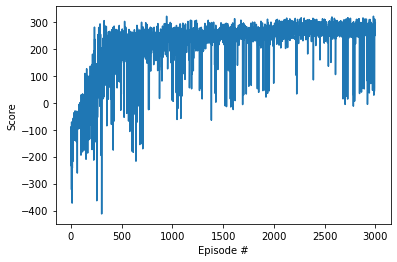

In [14]:
def dqn(n_episodes=3000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [16]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    done = False
    while not done:
        env.render()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  